## Import libaries and datasets

In [ ]:
import pandas as pd
from datetime import datetime
from datetime import date
import numpy as np
from dateutil.relativedelta import relativedelta
import datetime
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 5000000)

df = pd.read_csv('/Users/flatiron/scrap_projects/espn/shots.csv')
df = df.drop_duplicates(keep='first')
df = df.dropna()

mins_played_all = pd.read_csv('/Users/flatiron/scrap_projects/mins/mins.csv')
mins_played_all = mins_played_all.drop_duplicates(keep='first')
mins_played_all = mins_played_all.loc[mins_played_all['gameid'].astype(str).str.isdigit()]
mins_played_all = mins_played_all.rename(columns={'name':'player'})
mins_played_all['player'] = mins_played_all['player']+'/'+mins_played_all['team']
mins_played_all['gameid'] = mins_played_all['gameid'].astype(int)

In [ ]:
mins_played_all['pos'] = mins_played_all['pos'].astype(int)
mins_played_all['league'] = mins_played_all['league'].apply(lambda x: x.replace("-","/"))
mins_played_all = mins_played_all.drop_duplicates(keep='first')
mins_played_all['mins'] = mins_played_all['mins'].astype(int)

Select time periods to bet

In [ ]:
pre_betting_date = pd.to_datetime('2020-03-02 00:00:00')
post_betting_date = pd.to_datetime('2020-03-04 23:59:00')

Make selective wording changes

In [ ]:
df['details'] = df['details'].apply(lambda x: x.replace("1. FC Kaiserslautern","FC Kaiserslautern")
                                 .replace("D.C. United","DC United").replace("Queens Park Rangers","QPR")
                                   .replace("1. FC Union Berlin","FC Union Berlin")
                                    .replace("1. FC Köln","FC Cologne").replace("1. FSV Mainz 05","Mainz")
                                   .replace("1. FC","").replace("Hellas ","").replace("Athletic Club","Athletic Bilbao")
                                    .replace("Atlético de Madrid","Atletico Madrid")
                                    .replace("Paris Saint-Germain","Paris Saint Germain").replace("St. ","St "))
df['title'] = df['title'].apply(lambda x: x.replace("1. FC Kaiserslautern","FC Kaiserslautern")
                                .replace("Internazionale","Inter Milan").replace("Queens Park Rangers","QPR")
                                 .replace("D.C. United","DC United").replace("Audax - SP","Audax SP")
                               .replace("1. FC Union Berlin","FC Union Berlin").replace("St. ","St ")
                                .replace("AS ","").replace("Hellas ","")
                                .replace("Paris Saint-Germain","Paris Saint Germain").replace("AC ",""))
mins_played_all['team'] = mins_played_all['team'].apply(lambda x: x.replace("1. FC Kaiserslautern","FC Kaiserslautern")
                                .replace("Internazionale","Inter Milan").replace("Queens Park Rangers","QPR")
                                 .replace("D.C. United","DC United").replace("Audax - SP","Audax SP")
                               .replace("1. FC Union Berlin","FC Union Berlin").replace("St. ","St ")
                                .replace("AS ","").replace("Hellas ","")
                                .replace("Paris Saint-Germain","Paris Saint Germain").replace("AC ",""))

Data sorting

In [ ]:
df = df.loc[df['details'].str.startswith(('Attempt','Goal!'))]
df['gameid'] = df['link'].str[-6:].astype(int)
df = df.loc[(df['mins']!='-')]
df = df.loc[(df['mins']!='')]
df = df.loc[(df['mins']!="'")]
df['mins'] = df['mins'].apply(lambda x: x.split("'")[0]).astype(int)
df['date'] = df['title'].apply(lambda x: x.split(" - ")[2])
df['title'] = df['title'].apply(lambda x: x.split(" - ")[0])
df['home'] = df['title'].apply(lambda x: x.split(" vs. ")[0].replace(".",""))
df['away'] = df['title'].apply(lambda x: x.split(" vs. ")[1].replace(".",""))
df['goal'] = df['details'].apply(lambda x: "Goal!" in x)*1
df['league'] = df['league'].apply(lambda x: x.split(",")[0])
df['player'] = df['details'].str.split(".", expand=True)[1].str.split(")", expand=True)[0]
df = df[~df.isna().any(axis=1)]
df['player'] = df['player'].apply(lambda x: x.replace(" (","/").strip())
df['goal'] = df['details'].apply(lambda x: "Goal!" in x)*1
df['date'] = pd.to_datetime(df['date'])
scorers = df.loc[(df['date']>=pre_betting_date) & (df['date']<=post_betting_date)]
scorers = scorers.groupby(['gameid','player'])['goal'].sum().reset_index()
df['attacking_team'] = df['player'].str.split("/", expand=True)[1]
df['defending_team'] = (
    np.where(df['attacking_team']==df['home'],df['away'],df['home']))

Sort data by shot location

In [ ]:
df['type'] = pd.np.where(df['details'].str.contains("shot from very close range"), "shot - very close range",
                pd.np.where(df['details'].str.contains("footed shot from a difficult angle and long range"), "shot - difficult angle and long range",
                pd.np.where(df['details'].str.contains("footed shot from long range on the"), "shot - long range",
                pd.np.where(df['details'].str.contains("attempt from the centre of the box"), "shot - centre of the box",
                pd.np.where(df['details'].str.contains("attempt from very close range "), "shot - very close range",
                pd.np.where(df['details'].str.contains("footed shot from the centre of the box"), "shot - centre of the box",
                pd.np.where(df['details'].str.contains("attempt from the left side of the six yard box"), "shot - side of the six yard box",
                pd.np.where(df['details'].str.contains("footed shot from a difficult angle on"), "shot - difficult angle",
                pd.np.where(df['details'].str.contains("header from very close range"), "header - very close range",
                pd.np.where(df['details'].str.contains("header from the right side of the six yard box"), "header - side of six yard box",
                pd.np.where(df['details'].str.contains("header from the left side of the six yard box"), "header - side of six yard box",                                                    
                pd.np.where(df['details'].str.contains("header from a difficult angle"), "header - difficult angle",                                                    
                pd.np.where(df['details'].str.contains("shot from the left side of the six yard box"), "shot - side of the six yard box",
                pd.np.where(df['details'].str.contains("shot from the right side of the six yard box"), "shot - side of the six yard box",
                pd.np.where(df['details'].str.contains("attempt from the right side of the six yard box is close"), "shot - side of the six yard box",
                pd.np.where(df['details'].str.contains("attempt from the left side of the six yard box is close"), "shot - side of the six yard box",
                pd.np.where(df['details'].str.contains("header from the left side of the box"), "header - side of the box",
                pd.np.where(df['details'].str.contains("header from the right side of the box"), "header - side of the box",
                pd.np.where(df['details'].str.contains("shot from the right side of the box"), "shot - side of the box",
                pd.np.where(df['details'].str.contains("shot from the left side of the box"), "shot - side of the box",
                pd.np.where(df['details'].str.contains("attempt from the left side of the box"), "shot - side of the box",
                pd.np.where(df['details'].str.contains("attempt from the right side of the box"), "shot - side of the box",
                pd.np.where(df['details'].str.contains("shot from outside the box"), "shot - outside the box",                            
                pd.np.where(df['details'].str.contains("footed shot from more than"), "shot - long range",  
                pd.np.where(df['details'].str.contains("penalty"), "penalty",                              
                pd.np.where(df['details'].str.contains("header from the centre of the box"), "header - centre of the box", "leave"))))))))))))))))))))))))))
df['pen_taker'] = pd.np.where(df['details'].str.contains("penalty"), 1, 0)

In [ ]:
df = df.loc[~(df['type']=='leave')]
df = df.loc[df['player'].str.contains('/')]
pen_taker = df.groupby(['player'])['pen_taker'].sum().reset_index()
df = df.loc[~(df['type']=='penalty')]

In [ ]:
df['player'] = df['player'].apply(lambda x: x.split('/')[0])

In [24]:
df = df.loc[df['league']=='2019-20 English Premier League']

In [25]:
xg_league_mean = round(df.groupby(['type', 'league'])['goal'].mean().reset_index(),3)
xg_league_mean.columns = ['type', 'league','xg']
xg_league_count = round(df.groupby(['type', 'league'])['goal'].count().reset_index(),3)
xg_league_count.columns = ['type', 'league','shots']
xg_league = xg_league_mean.merge(xg_league_count)
xg_mean = round(df.groupby(['type'])['goal'].mean().reset_index(),3)
xg_mean.columns = ['type','xg_avg']

xg_league = xg_league.merge(xg_mean)
xg_league['xg'] = pd.np.where(xg_league['shots']<500,xg_league['xg_avg'],xg_league['xg'])
xg_league = xg_league.iloc[:,:3]
df = pd.merge(df, xg_league,  how='left', left_on=['type','league'], right_on = ['type','league'])

xg_player_mean = round(df.groupby(['type', 'player'])['goal'].mean().reset_index(),3)
xg_player_mean.columns = ['type', 'player','xg']
xg_player_count = round(df.groupby(['type', 'player'])['goal'].count().reset_index(),3)
xg_player_count.columns = ['type', 'player','shots']
xg_player = xg_player_mean.merge(xg_player_count)
xg_player = xg_player.loc[(xg_player['shots']>=20)]

df = pd.merge(df, xg_player.iloc[:,:-1],  how='left', left_on=['type','player'], right_on = ['type','player'])
df['xg'] = df.apply(lambda x: x['xg_x'] if pd.isnull(x['xg_y']) else x['xg_y'], axis=1)

In [13]:
xg_total_player = df.groupby(['player'])['xg'].agg(['sum']).reset_index().sort_values('sum')
xg_total_player.columns = ['player','xg']
goals_total_player = df.groupby(['player'])['goal'].agg(['sum']).reset_index().sort_values('sum')
goals_total_player.columns = ['player','goals']

### Carry out linear regression test

In [38]:
lin_reg = xg_total_player.merge(goals_total_player)

lin_reg.tail(40)

,player,xg,goals
365,Ismaila Sarr,4.405,5
366,David McGoldrick,4.437,0
367,Bernardo Silva,4.468,5
368,Ashley Barnes,4.550,5
369,Ayoze Pérez,4.674,6
370,Riyad Mahrez,4.677,5
371,Harry Kane,4.738,9
372,Wesley,4.820,5
373,Todd Cantwell,4.996,6
374,Christian Pulisic,5.006,5


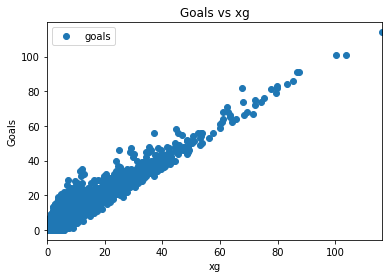

In [69]:
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 

lin_reg.plot(x='xg', y='goals', style='o')  
plt.title('Goals vs xg')  
plt.xlabel('xg')  
plt.ylabel('Goals')  
plt.show()

In [70]:
X = lin_reg['xg'].values.reshape(-1,1)
y = lin_reg['goals'].values.reshape(-1,1)

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
model = sm.OLS(y, X).fit()
model.summary()

In [28]:
pd.merge(mins_played_all,df[['gameid','date']],on='gameid', how='left').drop_duplicates(keep='first')

,gameid,pos,player,league,team,mins,date_x,date_y
0,540000,1,Nicolás Peranic/Melipilla,"2019 Copa Chile, Second Round",Melipilla,90,NaT,NaT
1,540000,2,José Luis Cabión/Melipilla,"2019 Copa Chile, Second Round",Melipilla,74,NaT,NaT
2,540000,3,Gonzalo Lauler/Melipilla,"2019 Copa Chile, Second Round",Melipilla,90,NaT,NaT
3,540000,4,Miguel Sanhueza/Melipilla,"2019 Copa Chile, Second Round",Melipilla,90,NaT,NaT
4,540000,5,Mario Sandoval/Melipilla,"2019 Copa Chile, Second Round",Melipilla,90,NaT,NaT
...,...,...,...,...,...,...,...,...
1635809,561988,11,Sergio León/Levante,"2019/20 Spanish Copa del Rey, Second Round",Levante,79,NaT,NaT
1635810,561988,12,Aitor Fernández/Levante,"2019/20 Spanish Copa del Rey, Second Round",Levante,68,NaT,NaT
1635811,561988,13,Roger Martí/Levante,"2019/20 Spanish Copa del Rey, Second Round",Levante,-7,NaT,NaT
1635812,561988,14,Enis Bardhi/Levante,"2019/20 Spanish Copa del Rey, Second Round",Levante,26,NaT,NaT


#### The expected goals metric shows a high r^2, and visually there is a strong correlation (within the data).

I have omitted the second half of my code as shows the remaining steps to complete the profitable sports betting model.

I used a combiantion of logsitical regression, grid search CV, conditional algorithms and monte carlo simualtion, as well as certain libaries like fuzzywuzzy match.